<a href="https://colab.research.google.com/github/gekoramy/uni.deep-learning/blob/clip/clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP
This is a self-contained notebook that shows how to download and run CLIP models.

References:
*   [clip github repository](https://github.com/openai/CLIP/tree/main)
*   [interacting with clip](https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb)



## Preparation for Colab
Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-otg28zt1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-otg28zt1
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=d894df06a8018b7cce5366569029f2aaef419f60c2a963234b34d4d4dcc5c081
  Stored in directory: /tmp/pip-ephem-wheel-cache-006xk__c/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.0.0+cu118


## Loading the model

`clip.available_models()` will list the names of available CLIP models. According to the project assignment, it is required to use ResNet. 

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

...and load one of them. For this, we can use the `clip.load()` function and specify the name of the model we want to use.

`clip.load(name, device=..., jit=False)`

Returns the model and the TorchVision transform needed by the model, specified by the model name returned by `clip.available_models()`. It will download the model as necessary. The `name` argument can also be a path to a local checkpoint.

The device to run the model can be optionally specified, and the default is to use the first CUDA device if there is any, otherwise the CPU. When jit is False, a non-JIT version of the model will be loaded.

In [4]:
model, preprocess = clip.load("RN50")
model = model.cuda().eval()

100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 178MiB/s]


By inspecting some variables, we can better understand the structure of the architecture we loaded.

**TODO** at the moment I do not undestand properly the meaning of these infos:
- 224 is related to the image dim according to the following code blocks.
- 77 is the number of token which are expected given a sentence



In [5]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fe56eedc9d0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

`clip.tokenize(text: Union[str, List[str]], context_length=77)`

Returns a LongTensor containing tokenized sequences of given text input(s). This can be used as the input to the model.

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [8]:
clip.tokenize("Hello World!").shape

torch.Size([1, 77])

In [9]:
clip.tokenize(["Hello World!", "ciao ciao"])

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406, 37677, 37677, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

In [10]:
clip.tokenize(["Hello World!", "ciao ciao"]).shape

torch.Size([2, 77])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [11]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

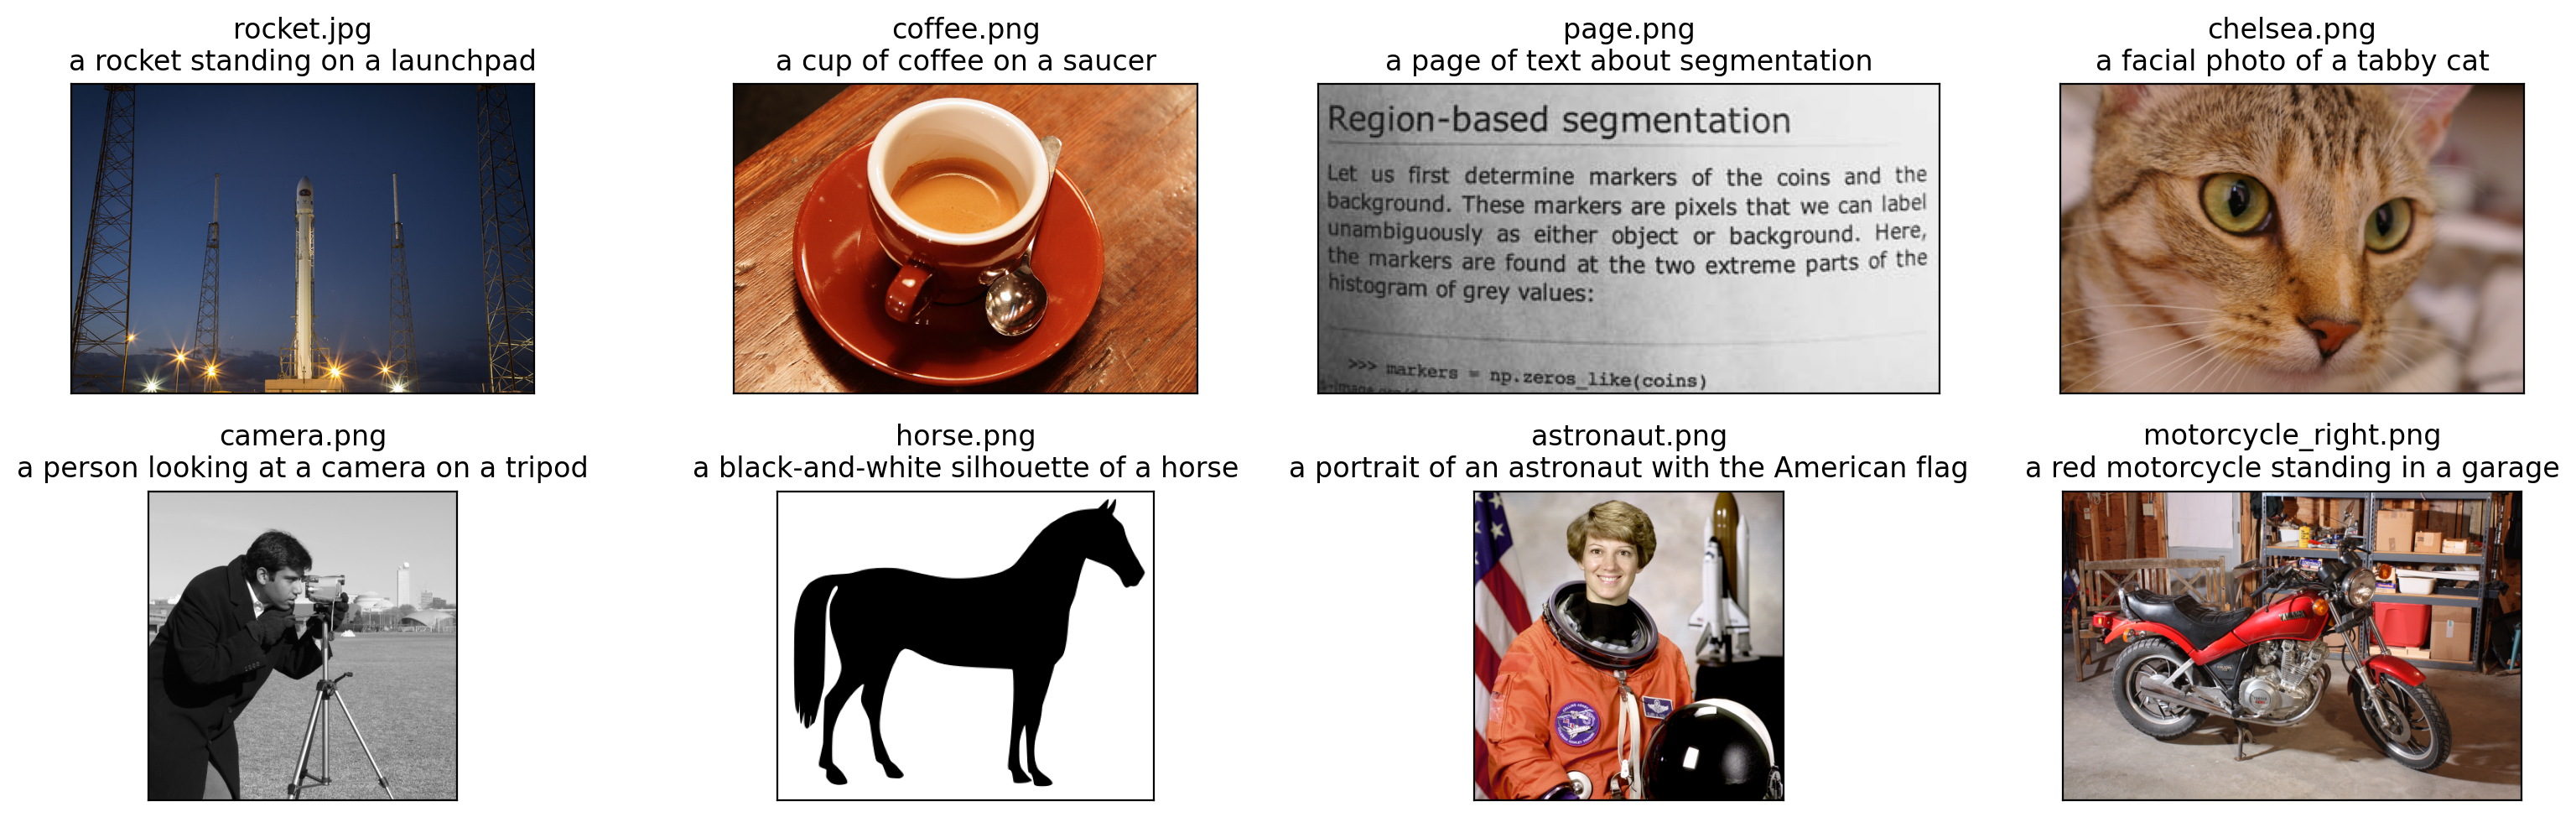

In [27]:
original_images = []
images = []
texts = []
fileNames = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))  #preprocess
    fileNames.append(os.path.join(skimage.data_dir, filename))
    texts.append(descriptions[name])

plt.tight_layout()

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

- `stack()` is used for joining multiple NumPy arrays. Unlike, concatenate(), it joins arrays along a new axis. It returns a NumPy array.

- to join 2 arrays, they must have the same shape and dimensions. (e.g. both (2,3)–> 2 rows,3 columns)

- `stack()` creates a new array which has 1 more dimension than the input arrays. If we stack 2 1-D arrays, the resultant array will have 2 dimensions.

More info about stack: [link](https://www.geeksforgeeks.org/numpy-stack-in-python/)

In [28]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [29]:
image_input.shape, text_tokens.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8, 77]))

`model.encode_image(image: Tensor)`

Given a batch of images, returns the image features encoded by the vision portion of the CLIP model.

`model.encode_text(text: Tensor)`

Given a batch of text tokens, returns the text features encoded by the language portion of the CLIP model.

In [30]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [31]:
image_features.shape, text_features.shape

(torch.Size([8, 1024]), torch.Size([8, 1024]))

`model(image: Tensor, text: Tensor)`

Given a batch of images and a batch of text tokens, returns two Tensors, containing the logit scores corresponding to each image and text input. The values are cosine similarities between the corresponding image and text features, times 100.

In [32]:
with torch.no_grad():
  logits_per_image, logits_per_text = model(image_input, text_tokens)
  probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [33]:
type(logits_per_image), type(logits_per_text)

(torch.Tensor, torch.Tensor)

In [34]:
logits_per_image.shape, logits_per_text.shape

(torch.Size([8, 8]), torch.Size([8, 8]))

In [35]:
logits_per_image

tensor([[23.5938,  6.9883, 10.3672,  9.1875, 13.1719,  7.7461, 15.4844,  4.8438],
        [10.3906, 24.3750, 13.9688, 13.7109, 12.2578, 10.7188,  8.6641,  8.3906],
        [11.0938, 11.7031, 27.7031, 13.1875, 12.5859, 15.2500,  7.5117,  5.4492],
        [14.5781, 13.5391, 14.5469, 26.1406, 16.7344,  7.6328,  9.7812,  9.2109],
        [18.0625, 11.2500, 11.9609, 11.5625, 23.9688, 15.5625, 14.3672,  4.8516],
        [12.4453, 10.9453, 14.1484, 12.0703, 14.0938, 29.6875, 10.7578, 11.4062],
        [16.5312, 11.1328, 10.1797, 14.5625, 12.9609,  7.5781, 22.9688, 10.1562],
        [11.9219,  8.3203,  7.9727,  7.1758,  8.1562,  6.3008,  7.3828, 27.0156]],
       device='cuda:0', dtype=torch.float16)

In [36]:
logits_per_text

tensor([[23.5938, 10.3906, 11.0938, 14.5781, 18.0625, 12.4453, 16.5312, 11.9219],
        [ 6.9883, 24.3750, 11.7031, 13.5391, 11.2500, 10.9453, 11.1328,  8.3203],
        [10.3672, 13.9688, 27.7031, 14.5469, 11.9609, 14.1484, 10.1797,  7.9727],
        [ 9.1875, 13.7109, 13.1875, 26.1406, 11.5625, 12.0703, 14.5625,  7.1758],
        [13.1719, 12.2578, 12.5859, 16.7344, 23.9688, 14.0938, 12.9609,  8.1562],
        [ 7.7461, 10.7188, 15.2500,  7.6328, 15.5625, 29.6875,  7.5781,  6.3008],
        [15.4844,  8.6641,  7.5117,  9.7812, 14.3672, 10.7578, 22.9688,  7.3828],
        [ 4.8438,  8.3906,  5.4492,  9.2109,  4.8516, 11.4062, 10.1562, 27.0156]],
       device='cuda:0', dtype=torch.float16)

# Compute cosine similarity
Both the code suggested by the professor and the example provieded by CLIP do not use the `model` method to compute the similarities.

**Remark:** reading the code of the professor I notice that he wrote a handy funcion to encode the data:



```
def encode_data(images_fp: list[str], texts: list[str]):
  # preprocess the images to transform from filenames to images to tensors
  images = [preprocess(Image.open(image)) for image in images_fp]

  # preprocess the texts to transform from text to tensors
  images = torch.tensor(np.stack(images)).cuda()
  text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

  # encode the inputs
  with torch.no_grad():
    images_z = model.encode_image(images).float()
    texts_z = model.encode_text(text_tokens).float()
  
  return images_z, texts_z
```



We can now evaluate the similarity between the set of images and the set of textual descriptions that we created. We can expect that the similarity will be higher for the pairs that we plotted earlier.

Initially, **it is vital** to normalize the features to make them "compatible" and facilitate reasoning in the feature space. Since the results are identical, I suppose that the model `method` performs a normalization step.

In [37]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
  # normalise the image and the text
  images_z /= images_z.norm(dim=-1, keepdim=True)
  texts_z /= texts_z.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  similarity = (texts_z @ images_z.T)

  return similarity.cpu()

#images_fp, texts = get_data()
#images_z, texts_z = encode_data(images_fp, texts)
similarity = cosine_similarity(image_features, text_features)
print(similarity)

tensor([[0.2360, 0.1039, 0.1111, 0.1458, 0.1807, 0.1245, 0.1654, 0.1192],
        [0.0699, 0.2437, 0.1171, 0.1353, 0.1125, 0.1095, 0.1114, 0.0832],
        [0.1036, 0.1397, 0.2771, 0.1454, 0.1196, 0.1415, 0.1018, 0.0796],
        [0.0919, 0.1370, 0.1319, 0.2614, 0.1156, 0.1207, 0.1457, 0.0717],
        [0.1318, 0.1225, 0.1259, 0.1673, 0.2397, 0.1410, 0.1297, 0.0815],
        [0.0774, 0.1071, 0.1524, 0.0763, 0.1556, 0.2969, 0.0758, 0.0630],
        [0.1548, 0.0866, 0.0751, 0.0977, 0.1436, 0.1075, 0.2297, 0.0738],
        [0.0485, 0.0839, 0.0545, 0.0921, 0.0485, 0.1140, 0.1017, 0.2702]])


As anticipated, the similarity is higher on the diagonal, i.e., for the pairs that we defined earlier. We can also visualize these values to make it more explicit.

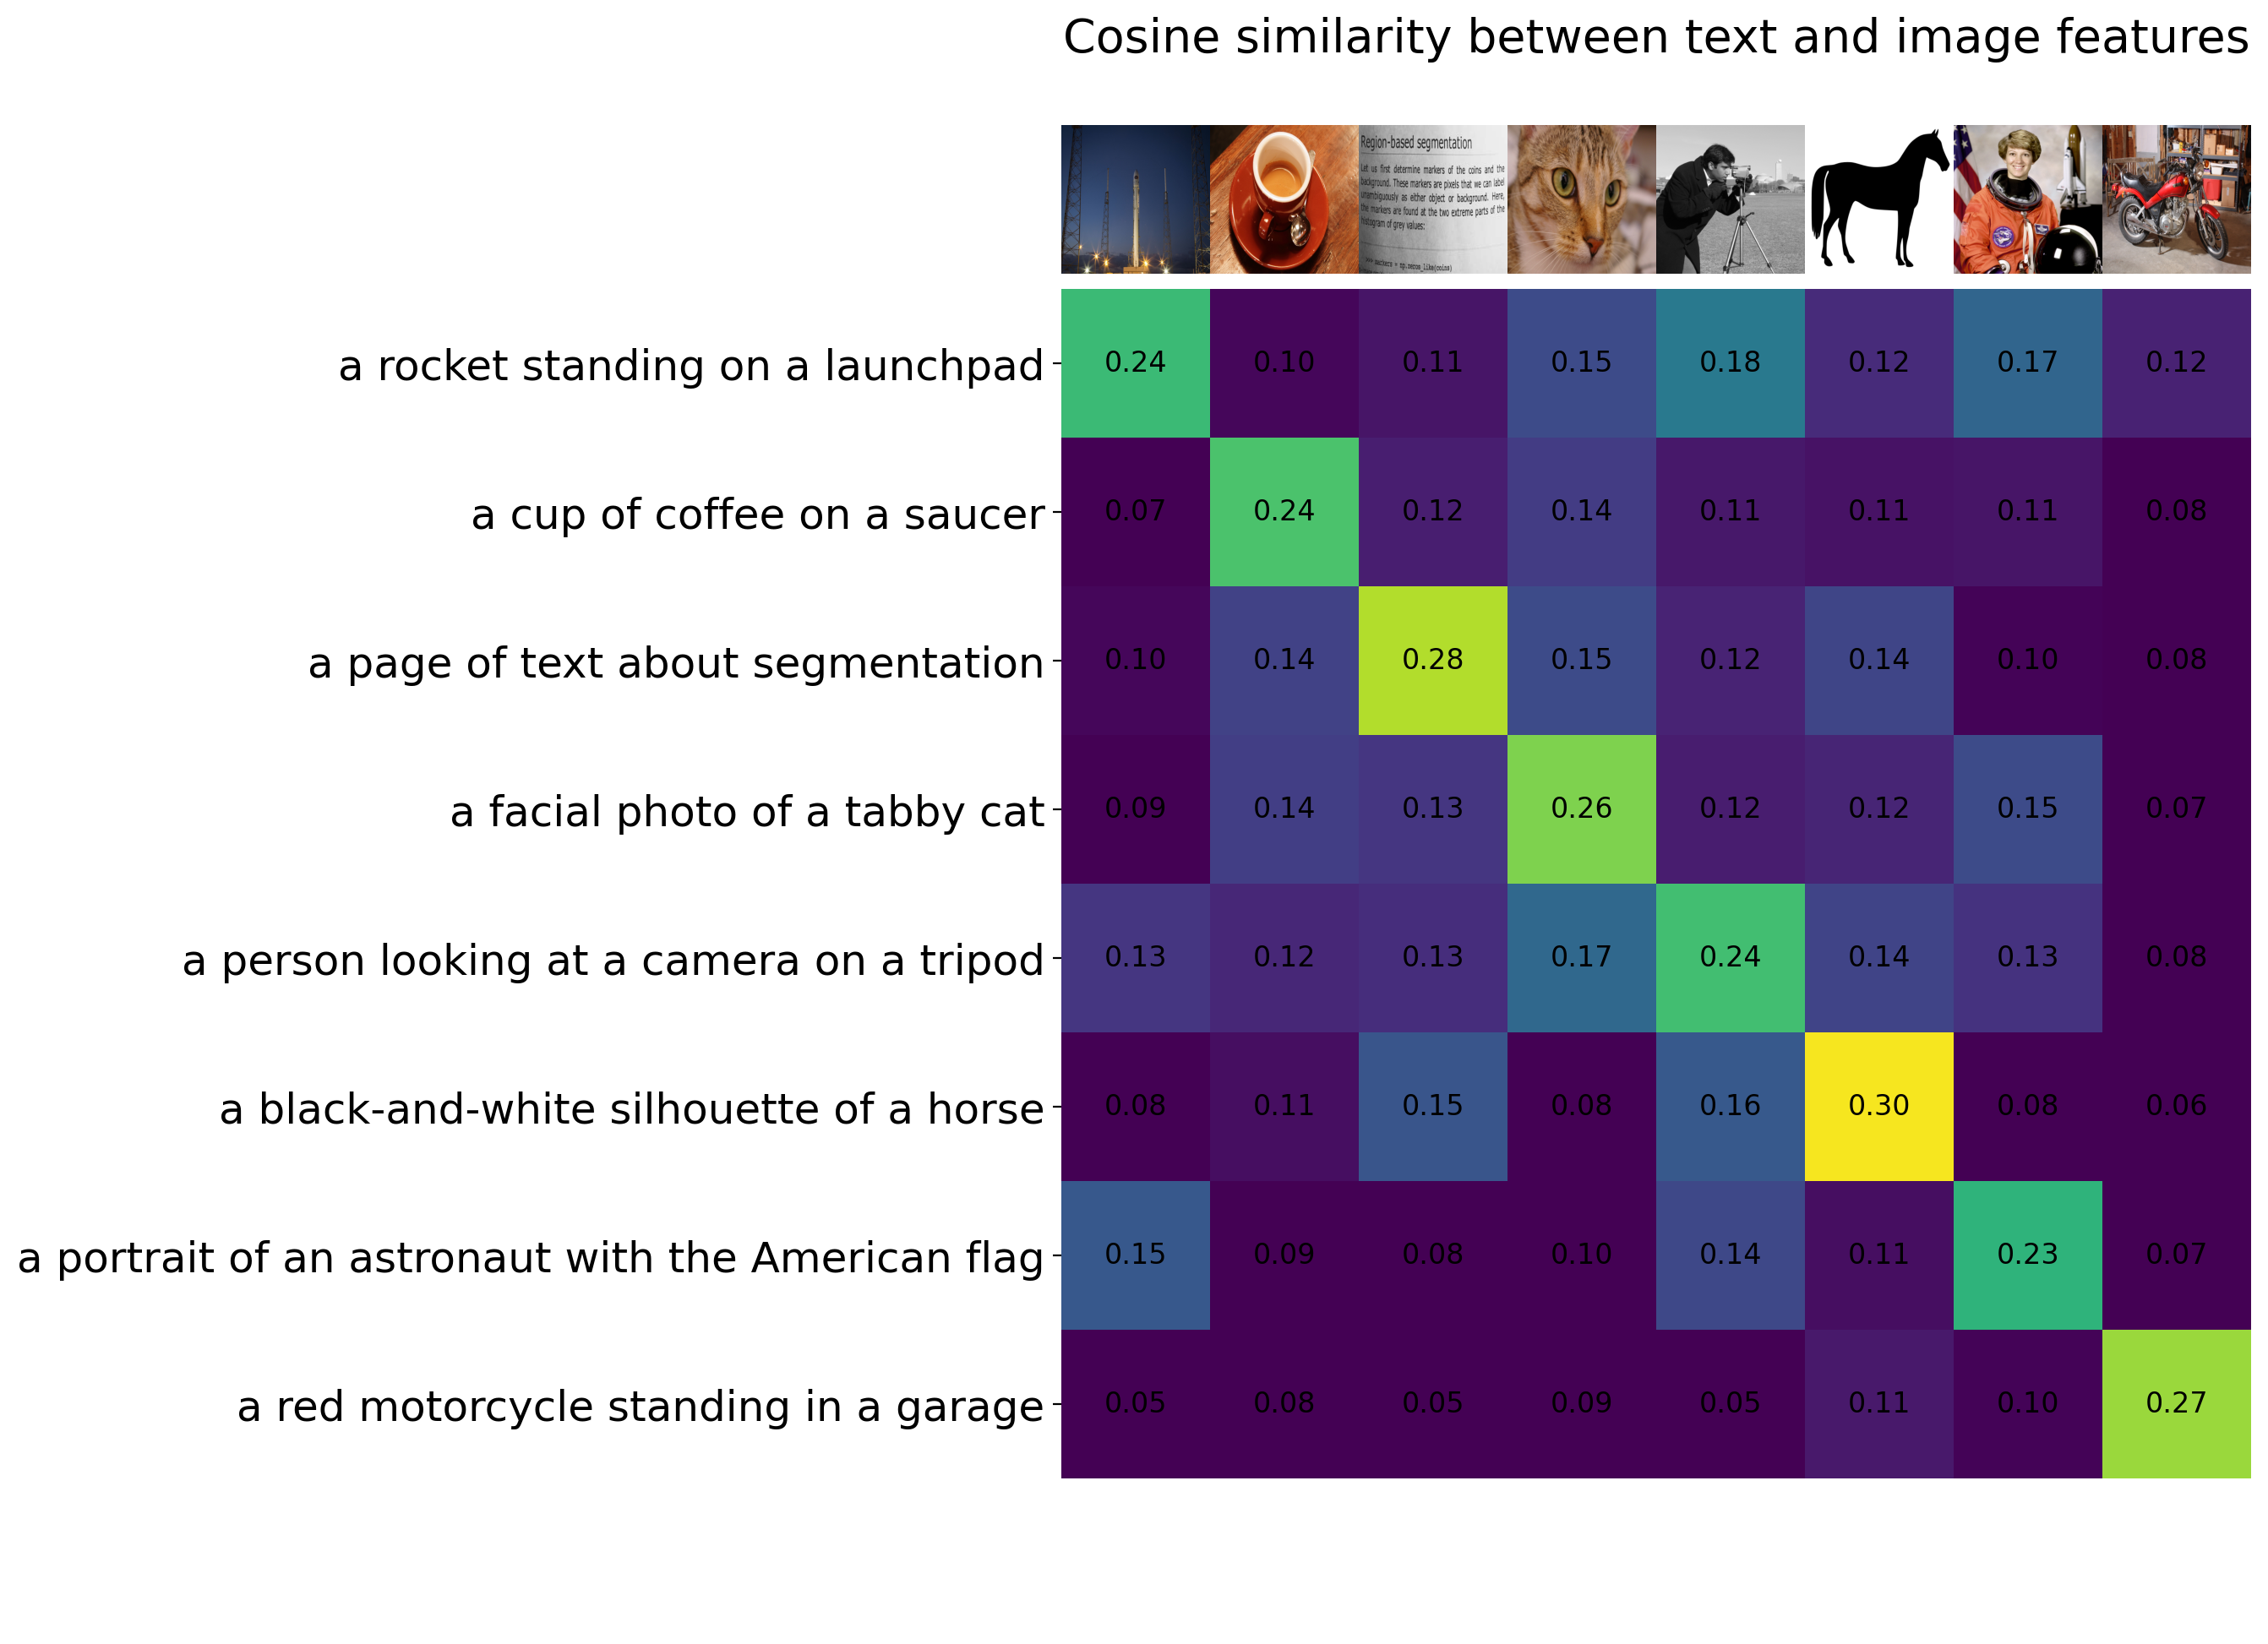

In [39]:
def visualise_similarity(similarity: torch.Tensor, images_fp: list[str], texts: list[str]):
  similarity = similarity.numpy()
  count = len(texts)

  # create a matplotlib figure object
  plt.figure(figsize=(18, 12))

  # show similarity scores
  plt.imshow(similarity, vmin=0.1, vmax=0.3)

  # update plot ticks
  plt.yticks(range(count), texts, fontsize=18)
  plt.xticks([])

  # visualise each image
  for i, image_fp in enumerate(images_fp):
    image = Image.open(image_fp).convert("RGB")
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

  # print the scores
  for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
      plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

  # update spines
  for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

  # change plot limits
  plt.xlim([-0.5, count - 0.5])
  plt.ylim([count + 0.5, -2])

  # set title
  plt.title("Cosine similarity between text and image features", size=20)

visualise_similarity(similarity, fileNames, texts)